## Decision Trees & Ensemble Learning

### 6.1: Credit Risk Scoring Project

In [76]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 6.2: Data Cleaning & Preparation

In [6]:
df = pd.read_csv("../data/CreditScoring.csv")

df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [9]:
status_values = {
    1: "ok",
    2: "default",
    3: "unk"
}

df.status = df.status.map(status_values)

In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [14]:
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [15]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [17]:
df = df[df.status != "unk"].reset_index(drop=True)

In [20]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == "default").astype(int).values
y_val = (df_val.status == "default").astype(int).values
y_test = (df_test.status == "default").astype(int).values

del df_train["status"]
del df_val["status"]
del df_test["status"]

### 6.3: Decision Trees

In [29]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] > 6000:
            return "ok"
        else:
            return "default"

xi = df_train.iloc[0].to_dict()
assess_risk(xi)

'default'

In [33]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [32]:
dict_train = df_train.fillna(0).to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)

In [34]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [36]:
dict_val = df_val.fillna(0).to_dict(orient="records")
X_val = dv.transform(dict_val)

In [37]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6489113530326595

In [38]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999996527536635

In [39]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [45]:
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("val:", auc)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print("train:", auc)

val: 0.6830036873526313
train: 0.7351204944787832


In [46]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 9.50
|   |   |--- class: 1
|   |--- seniority >  9.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- income <= 100.50
|   |   |--- class: 0
|   |--- income >  100.50
|   |   |--- class: 0



### 6.4: Decision Tree Learning Algorithm

In [48]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [51]:
df_example.sort_values("assets")

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [54]:
from IPython.display import display

ts = [0, 2000, 3000, 4000, 5000, 8000, 9000]
for t in ts:
    print(t)
    df_left = df_example[df_example.assets <= t]
    df_right = df_example[df_example.assets > t]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))

    display(df_right)
    print(df_right.status.value_counts(normalize=True), end="\n\n")


0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64

9000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status


Series([], Name: proportion, dtype: float64)



In [55]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [57]:
df_example.sort_values("debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [61]:
feature_ts = {
    "assets": [0, 2000, 3000, 4000, 5000, 8000, 9000],
    "debt": [500, 1000, 2000]
}

for feature, ts in feature_ts.items():
    print(feature)
    for t in ts:
        print(t)
        df_left = df_example[df_example[feature] <= t]
        df_right = df_example[df_example[feature] > t]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))

        display(df_right)
        print(df_right.status.value_counts(normalize=True))
    print("=================================")

assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
9000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64
2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


### 6.5: Decision Tree Parameter Tuning

In [67]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"{d} -> {auc:.3f}")

1 -> 0.598
2 -> 0.683
3 -> 0.742
4 -> 0.776
5 -> 0.777
6 -> 0.764
10 -> 0.690
15 -> 0.663
20 -> 0.664
None -> 0.661


In [69]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [70]:
columns = ["max_depth", "min_samples_leaf", "auc"]
df_score = pd.DataFrame(scores, columns=columns)

In [74]:
df_score_pivot = df_score.pivot(index="min_samples_leaf", columns=["max_depth"], values=["auc"])
df_score_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.776  0.777  0.764
5                 0.776  0.777  0.777
10                0.776  0.783  0.775
15                0.777  0.784  0.776
20                0.778  0.790  0.783
50                0.770  0.783  0.786
100               0.773  0.789  0.787
200               0.770  0.770  0.770

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

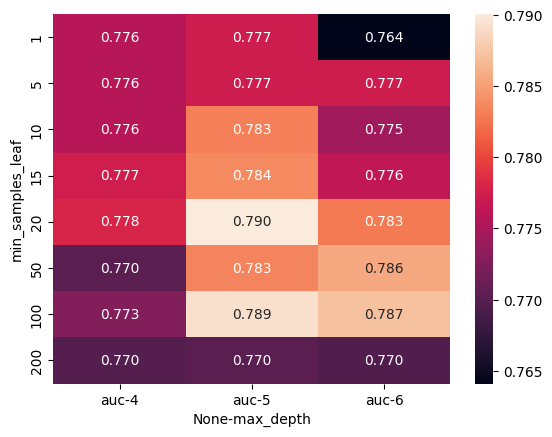

In [78]:
sns.heatmap(df_score_pivot, annot=True, fmt=".3f")

In [79]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [81]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 9.50
|   |   |--- home=owner <= 0.50
|   |   |   |--- amount <= 910.50
|   |   |   |   |--- expenses <= 50.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- expenses >  50.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- amount >  910.50
|   |   |   |   |--- home=parents <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- home=parents >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- home=owner >  0.50
|   |   |   |--- income <= 136.50
|   |   |   |   |--- amount <= 1175.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- amount >  1175.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- income >  136.50
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- class: 0
|   |--- seniority >  9.50
|   |   |--- assets <= 3250.00
|   |   |   |--- amount <= 1015.00
|   |   |   |   |--- class: 0
|   |   |   |--- amount >  1015.00
|

### 6.6: Ensembles & Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [86]:
df_score = pd.DataFrame(scores, columns=["n_estimators", "auc"])

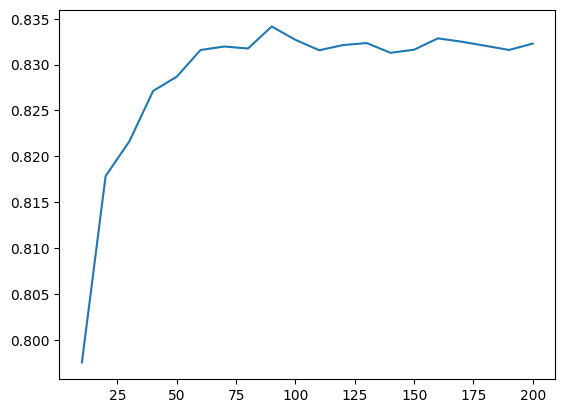

In [87]:
plt.plot(df_score.n_estimators, df_score.auc)

In [100]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, n, auc))

In [101]:
columns = ["max_depth", "n_estimators", "auc"]
df_score = pd.DataFrame(scores, columns=columns)

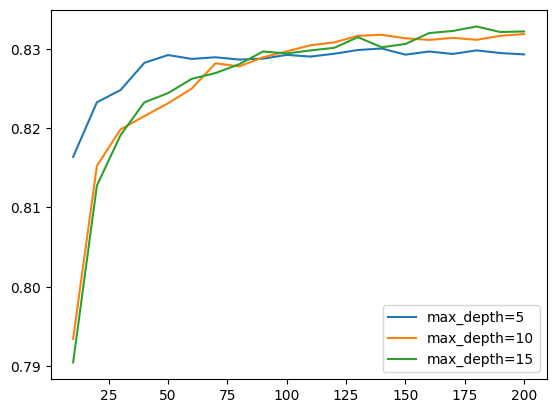

In [102]:
for d in [5, 10, 15]:
    df_subset = df_score[df_score.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f"max_depth={d}")

plt.legend()

In [103]:
max_depth = 10

In [104]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [105]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_score = pd.DataFrame(scores, columns=columns)

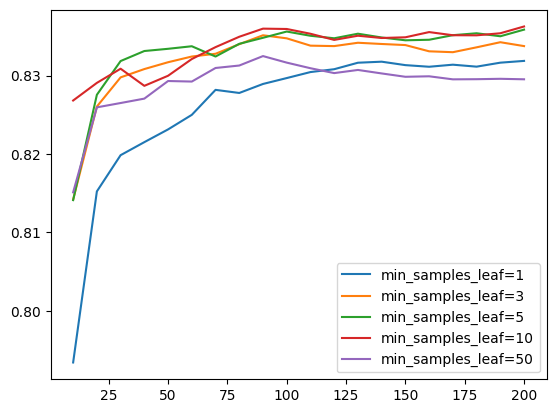

In [107]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_score[df_score.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f"min_samples_leaf={s}")

plt.legend()

In [108]:
min_samples_leaf = 5

In [111]:
rf = RandomForestClassifier(n_estimators=200,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 6.7: Gradient Boosting & XGBoost

In [112]:
import xgboost as xgb

In [113]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [114]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "nthread": 2,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [115]:
y_pred = model.predict(dval)

In [116]:
roc_auc_score(y_val, y_pred)

0.8314729343300056

In [117]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [118]:
%%capture output

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 2,
    "seed": 1,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [125]:
print(output.stdout[:200].strip())

[0]	train-auc:0.86580	val-auc:0.78803
[5]	train-auc:0.93145	val-auc:0.82591
[10]	train-auc:0.95521	val-auc:0.83246
[15]	train-auc:0.96930	val-auc:0.83466
[20]	train-auc:0.97539	val-auc:0.83618
[25]	tr


In [126]:
def parse_xgb_output(output):
    result = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        result.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_result = pd.DataFrame(result, columns=columns)
    return df_result

In [127]:
df_score = parse_xgb_output(output)

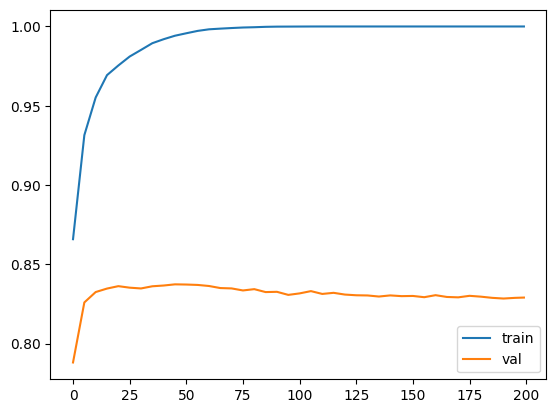

In [128]:
plt.plot(df_score.num_iter, df_score.train_auc, label="train")
plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.legend()

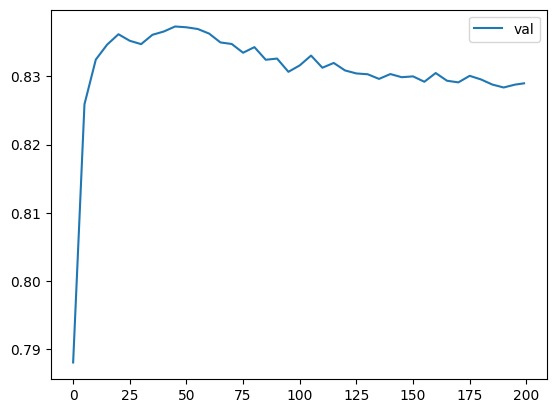

In [129]:
plt.plot(df_score.num_iter, df_score.val_auc, label="val")
plt.legend()

### 6.8: XGBoost Parameter Tuning

In [156]:
scores = {}

for eta in [0.01, 0.05, 0.1, 0.3, 1.0]:
    evals_result = {}

    xgb_params = {
        "eta": eta,
        "max_depth": 6,
        "min_child_weight": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
    }
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, 
                      verbose_eval=0, evals=watchlist, evals_result=evals_result)

    columns = ["num_iter", "train_auc", "val_auc"]
    train_aucs = list(evals_result["train"].values())[0]
    val_aucs = list(evals_result["val"].values())[0]

    df_result = pd.DataFrame(list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
                            columns=columns)

    key = f"eta={eta}"
    scores[key] = df_result

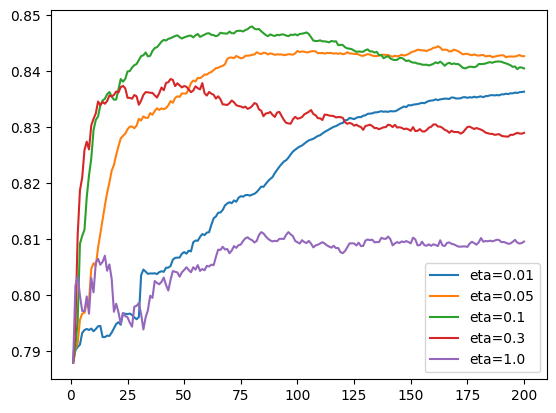

In [158]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f"{eta}")
plt.legend()

In [168]:
scores = {}

for d in [3, 4, 6]:
    evals_result = {}

    xgb_params = {
        "eta": 0.1,
        "max_depth": d,
        "min_child_weight": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
    }
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, 
                      verbose_eval=0, evals=watchlist, evals_result=evals_result)

    columns = ["num_iter", "train_auc", "val_auc"]
    train_aucs = list(evals_result["train"].values())[0]
    val_aucs = list(evals_result["val"].values())[0]

    df_result = pd.DataFrame(list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
                            columns=columns)

    key = f"max_depth={d}"
    scores[key] = df_result

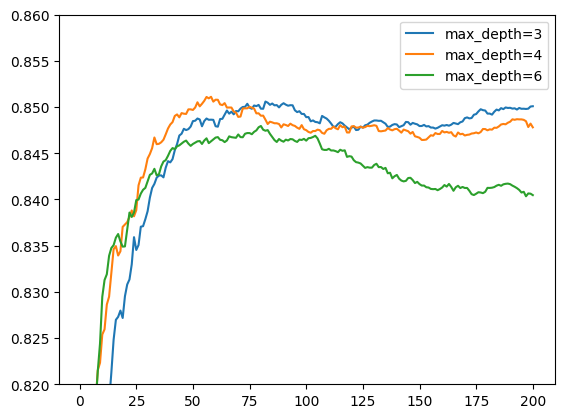

In [169]:
for depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f"{depth}")
plt.ylim(0.82, 0.86)
plt.legend()

In [171]:
scores = {}

for s in [1, 10, 30]:
    evals_result = {}

    xgb_params = {
        "eta": 0.1,
        "max_depth": 3,
        "min_child_weight": s,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
    }
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=200, 
                      verbose_eval=0, evals=watchlist, evals_result=evals_result)

    columns = ["num_iter", "train_auc", "val_auc"]
    train_aucs = list(evals_result["train"].values())[0]
    val_aucs = list(evals_result["val"].values())[0]

    df_result = pd.DataFrame(list(zip(range(1, len(train_aucs) + 1), train_aucs, val_aucs)),
                            columns=columns)

    key = f"min_child_weight={s}"
    scores[key] = df_result

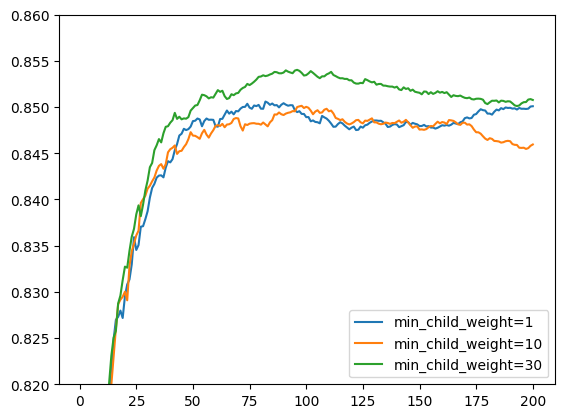

In [173]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f"{min_child_weight}")
plt.ylim(0.82, 0.86)
plt.legend()

In [174]:
xgb_params = {
        "eta": 0.1,
        "max_depth": 3,
        "min_child_weight": 30,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=125)

### Selecting the Final Model

In [175]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.790074875834044

In [176]:
rf = RandomForestClassifier(n_estimators=200,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8353045201424772

In [177]:
xgb_params = {
        "eta": 0.1,
        "max_depth": 3,
        "min_child_weight": 30,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=125)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8525874178497967

In [178]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == "default").astype(int).values
del df_full_train["status"]

In [179]:
dict_full_train = df_full_train.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

dict_test = df_test.to_dict(orient="records")
X_test = dv.transform(dict_test)

In [182]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))
dtest = xgb.DMatrix(X_test, feature_names=list(dv.get_feature_names_out()))

In [184]:
xgb_params = {
        "eta": 0.1,
        "max_depth": 3,
        "min_child_weight": 30,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "nthread": 2,
        "seed": 1,
        "verbosity": 1
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=125)

y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8275408109531333